# Fire Spread Simulation and Intervention Strategies

This notebook demonstrates a cellular automaton (CA) model for wildfire spread simulation and evaluates different intervention strategies. It uses real fire data from the MTBS (Monitoring Trends in Burn Severity) dataset for validation.

## Setup and Installation

First, we clone the project repository and install required dependencies.

In [ ]:
!git clone https://github.com/Coese/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 497 (delta 50), reused 13 (delta 13), pack-reused 428 (from 4)
Receiving objects: 100% (497/497), 11.27 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [2]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


In [ ]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap noise pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for noise: filename=noise-1.2.2-cp311-cp311-linux_x86_64.whl size=56281 sha256=be99311dd170bd7f26ce4b2d859d7d064fbd5b3a877709f9453aefb6438be09c
  Stored in directory: /root/.cache/pip/wheels/39/25/2e/af6d1bcc91a8f99af0f651f8718b9ab999720a21c6d4149091
Successfully built noise


## Import Libraries

Import the necessary Python libraries and custom modules for the fire simulation.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.model import CA

from noise import snoise2
import json

## Initialise Simulation Model

Load real fire data from the Arisona Pine Hollow fire and initialise the cellular automaton model with NDVI (Normalised Difference Vegetation Index) data.

In [ ]:
# Load the real Pine Hollow fire data
fire = "arizona"
grid_size = (250,250)


## Generate Terrain and Environmental Data

Create realistic terrain features using Simplex noise, including elevation, slope, aspect, and humidity data. These environmental factors significantly influence fire spread behavior.

In [ ]:
def generate_terrain_simplex(rows, cols, cell_size=30.0, min_elevation=100, max_elevation=1000,
                           octaves=6, persistence=0.5, lacunarity=2.0, scale=100.0, seed=None):
    """
    Generate realistic terrain elevation, slope, and aspect using Simplex noise.

    Parameters:
    - rows, cols: Dimensions of the grid
    - cell_size: size of each cell in meters
    - min_elevation, max_elevation: Range of elevation values in meters
    - octaves: Number of noise layers to combine (more = more detail)
    - persistence: How much each octave contributes (amplitude multiplier)
    - lacunarity: How frequency increases with each octave
    - scale: Base scale of the noise (higher = more gradual changes)
    - seed: Random seed for reproducibility

    Returns:
    - elevation: 2D numpy array of elevation values
    - slope: 2D numpy array of slope values in degrees
    - aspect: 2D numpy array of aspect values in degrees (0-360, 0=North)
    """

    if seed is not None:
        np.random.seed(seed)

    # Generate elevation using simplex noise
    elevation = np.zeros((rows, cols))

    # For better performance, vectorise the coordinates
    y_coords = np.linspace(0, scale, rows)
    x_coords = np.linspace(0, scale, cols)

    for octave in range(octaves):
        frequency = lacunarity ** octave
        amplitude = persistence ** octave

        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                elevation[i, j] += amplitude * snoise2(
                    y * frequency / scale,
                    x * frequency / scale
                )

    # Normalise to 0-1 range
    elevation_min = elevation.min()
    elevation_max = elevation.max()
    elevation = (elevation - elevation_min) / (elevation_max - elevation_min)

    # Scale to desired elevation range
    elevation = min_elevation + elevation * (max_elevation - min_elevation)

    # Calculate slope and aspect from elevation using gradients
    dy, dx = np.gradient(elevation, cell_size, cell_size)

    # Calculate slope in degrees
    # Slope is the angle of steepest descent
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Calculate aspect in degrees (0-360, clockwise from north)
    # Aspect is the direction of steepest descent
    aspect = np.degrees(np.arctan2(-dx, dy))
    # Convert to 0-360 range (0 = North)
    aspect = np.where(aspect < 0, aspect + 360, aspect)

    return elevation, slope, aspect

# Generate terrain using simplex noise instead of random values
elevation, slope, aspect = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=100,
    max_elevation=1000,
    scale=100.0,
    seed=42
)

# Adjust humidity based on elevation (higher elevation = typically lower humidity)
elevation_normalised = (elevation - 100) / 900  # Normalise to 0-1 range

### Dynamic Environmental Conditions using Stochastic Differential Equations

The model now supports stochastic environmental conditions that evolve realistically during the simulation.

In [ ]:
def run_dynamic_environment_simulation(model, steps=30, dt=0.1):
    """Run simulation with stochastic differential equation updates for environmental conditions"""
    history = [np.copy(model.grid)]
    env_history = []
    
    # Record initial environmental conditions
    env_history.append({
        'wind_speed': model.wind_speed,
        'wind_direction': model.wind_direction,
        'temperature': model.temperature,
        'humidity': np.mean(model.humidity),
        'precipitation': model.precipitation
    })
    
    for step in range(steps):
        # Update environmental conditions using SDEs
        env_conditions = model.update_environmental_conditions(dt=dt)
        env_history.append(env_conditions)
        
        # Update fire spread
        model.update()
        history.append(np.copy(model.grid))
        
        # Check if fire is contained
        if not np.any(model.grid == 1):
            print(f"Fire contained after {step+1} steps")
            break
    
    return history, env_history

def visualise_environmental_changes(env_history):
    """Visualise how environmental conditions change over time"""
    env_df = pd.DataFrame(env_history)
    
    # Create visualisation
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot wind speed over time
    axs[0, 0].plot(env_df['wind_speed'], 'b-')
    axs[0, 0].set_title('Wind Speed Evolution')
    axs[0, 0].set_xlabel('Simulation Step')
    axs[0, 0].set_ylabel('Wind Speed (m/s)')
    axs[0, 0].grid(True)
    
    # Plot wind direction over time
    axs[0, 1].plot(env_df['wind_direction'], 'g-')
    axs[0, 1].set_title('Wind Direction Evolution')
    axs[0, 1].set_xlabel('Simulation Step')
    axs[0, 1].set_ylabel('Wind Direction (degrees)')
    axs[0, 1].grid(True)
    
    # Plot temperature over time
    axs[1, 0].plot(env_df['temperature'], 'r-')
    axs[1, 0].set_title('Temperature Evolution')
    axs[1, 0].set_xlabel('Simulation Step')
    axs[1, 0].set_ylabel('Temperature (°F)')
    axs[1, 0].grid(True)
    
    # Plot humidity and precipitation
    ax1 = axs[1, 1]
    ax1.plot(env_df['humidity'], 'b-', label='Humidity')
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('Humidity (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(env_df['precipitation'], 'g-', label='Precipitation')
    ax2.set_ylabel('Precipitation (mm)', color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    
    # Add title
    ax1.set_title('Humidity and Precipitation Evolution')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Running simulation with stochastic environmental conditions...
Updated environmental conditions:
  Wind speed: 24.84 m/s
  Wind direction: 225.44°
  Temperature: 49.95°F
  Mean humidity: 5.32%
  Precipitation: 0.07 mm
 prob: 0.8784926111834965, we: 3.1734146172182335e-08, a_prob: 3.882118207495355e-09, tp: 0.3, p_density: 0.8018129615227354, humidity: 2.9533179902482085, temperature: 2.6355842165924788, precipitation: 1.0228711397182895, pc: 0.4688000751667608, exceeds_threshold: False
 prob: 0.8784926111834965, we: 3.1734146172182335e-08, a_prob: 9.662599835503188e-07, tp: 0.375, p_density: 0.7952676482798644, humidity: 2.953317990248

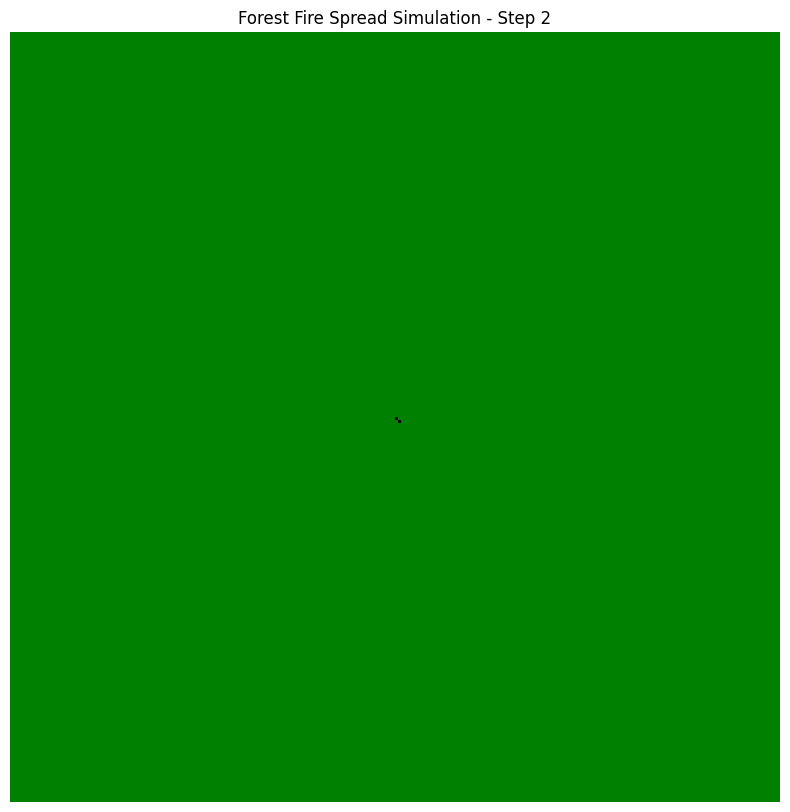

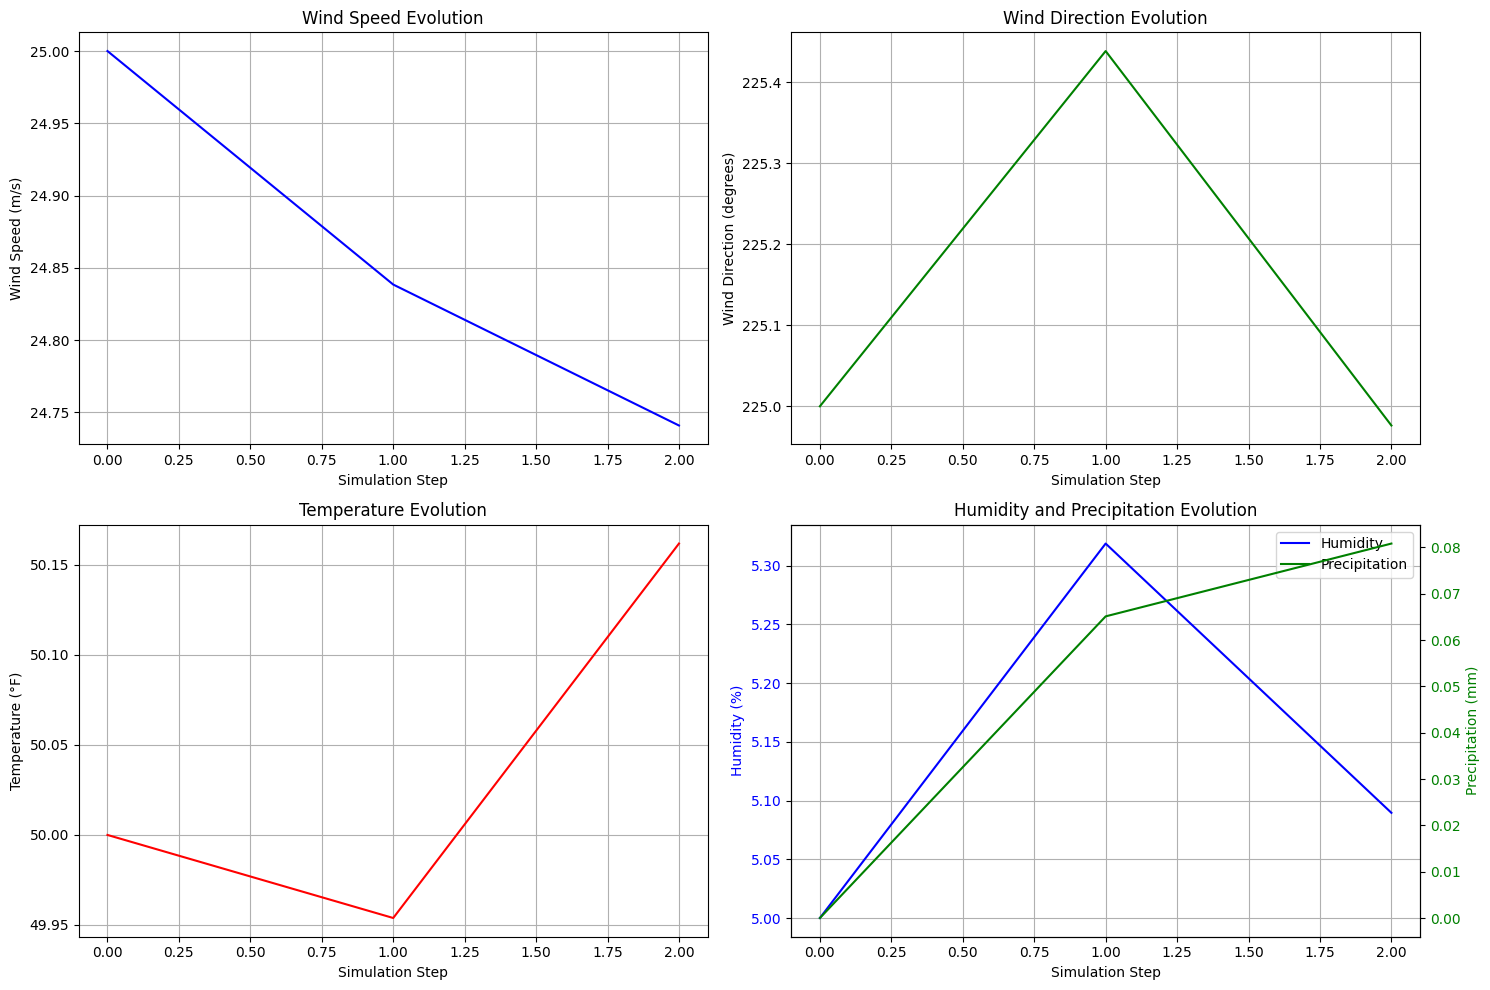

In [30]:
# Initialize model with optimal parameters
# optimal_params = {'p0': 0.6115, 'c1': 0.1225, 'c2': 0.3475} 
optimal_params = {'p0': 0.8784926111834965, 'c1': 0.4406809394875182, 'c2': 0.5968365681459044}

model_sde = CA(grid_size=grid_size, cell_size=1, params=optimal_params)
model_sde.load_mtbs_fire_data(fire)
model_sde.initialise_ndvi_from_data(fire)
model_sde.load_terrain_data(slope, aspect, elevation)

# Set initial environmental conditions
model_sde.set_environmental_data(wind_speed=25.0, wind_direction=225.0, 
                            temperature=50, humidity=5, fire_direction=20)

# Run simulation with dynamic environmental conditions
print("Running simulation with stochastic environmental conditions...")
history_sde, env_history = run_dynamic_environment_simulation(model_sde, steps=30, dt=0.1)

# Visualize results
model_sde.visualize_simulation(history_sde)
visualise_environmental_changes(env_history)

### 3. Percolation Theory Analysis

Percolation theory provides a more realistic model of fire spread across heterogeneous landscapes by accounting for critical thresholds in fuel connectivity.

In [ ]:
def analyse_percolation_landscape(model):
    """Analyse the percolation properties of the landscape"""
    # Calculate percolation thresholds across the landscape
    pc_map = np.zeros((model.rows, model.cols))
    exceeds_map = np.zeros((model.rows, model.cols))
    
    print("Calculating percolation thresholds for landscape...")
    for r in range(model.rows):
        for c in range(model.cols):
            pc, exceeds = model.calculate_percolation_threshold(r, c)
            pc_map[r, c] = pc
            exceeds_map[r, c] = 1 if exceeds else 0
    
    # Calculate summary statistics
    exceed_percentage = np.mean(exceeds_map) * 100
    avg_threshold = np.mean(pc_map)
    min_threshold = np.min(pc_map)
    max_threshold = np.max(pc_map)
    
    print(f"Percolation analysis complete:")
    print(f"  Average threshold: {avg_threshold:.4f}")
    print(f"  Threshold range: [{min_threshold:.4f}, {max_threshold:.4f}]")
    print(f"  Percentage of landscape exceeding threshold: {exceed_percentage:.1f}%")
    
    # Create visualisation
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot fuel density (NDVI)
    im1 = axs[0, 0].imshow(model.ndvi, cmap='YlGn')
    axs[0, 0].set_title('Fuel Density (NDVI)')
    plt.colorbar(im1, ax=axs[0, 0])
    
    # Plot percolation thresholds
    im2 = axs[0, 1].imshow(pc_map, cmap='plasma')
    axs[0, 1].set_title('Percolation Thresholds')
    plt.colorbar(im2, ax=axs[0, 1])
    
    # Plot areas exceeding threshold
    im3 = axs[1, 0].imshow(exceeds_map, cmap='RdYlGn')
    axs[1, 0].set_title('Areas Exceeding Percolation Threshold')
    plt.colorbar(im3, ax=axs[1, 0], ticks=[0, 1],
                label='0: Below Threshold, 1: Above Threshold')
    
    # Identify potential natural firebreaks
    from scipy import ndimage
    potential_firebreaks = ndimage.binary_dilation(exceeds_map > 0) & ~(exceeds_map > 0)
    im4 = axs[1, 1].imshow(potential_firebreaks, cmap='Reds')
    axs[1, 1].set_title('Potential Natural Firebreaks')
    plt.colorbar(im4, ax=axs[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return pc_map, exceeds_map, potential_firebreaks

Analysing landscape using percolation theory...
Calculating percolation thresholds for landscape...


c:\Users\Daniel\MX4553_Modelling_Theory_Project\src\model.py:145: RuntimeWarning: overflow encountered in exp
  slope_factor = np.exp((3.533 * (np.tan(slope))))


Percolation analysis complete:
  Average threshold: 0.4930
  Threshold range: [0.4069, 0.5927]
  Percentage of landscape exceeding threshold: 6.9%


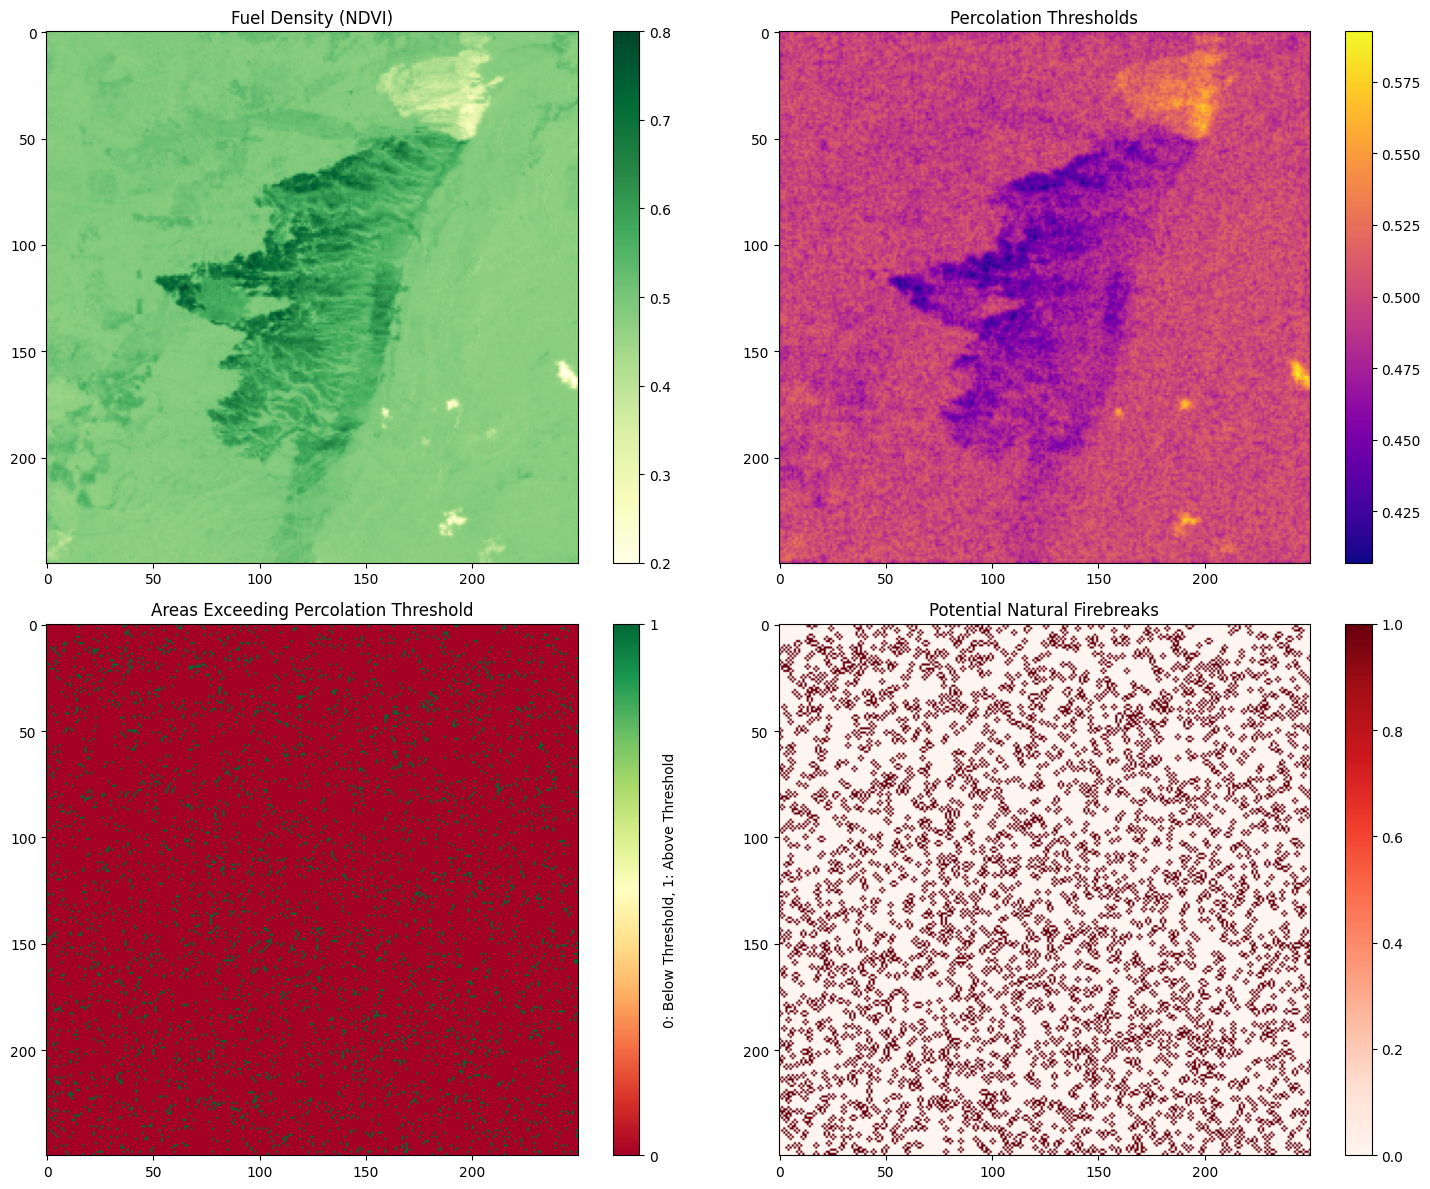

In [31]:
# Analyse percolation thresholds in the model
print("Analysing landscape using percolation theory...")
pc_map, exceeds_map, potential_firebreaks = analyse_percolation_landscape(model_sde)

### 5. Integrated Model with All Advanced Features

Now let's run a simulation that incorporates all the advanced features: percolation theory, stochastic differential equations for dynamic environment, and optimised parameters.

In [ ]:
def run_advanced_model(fire_folder, params, steps=30, dt=0.1):
    """Run advanced model with all enhanced features"""
    print("Initialising advanced model with all features...")
    model = CA(grid_size=grid_size, cell_size=30, params=params)
    model.load_mtbs_fire_data(fire_folder)
    model.initialise_ndvi_from_data(fire_folder)
    model.load_terrain_data(slope, aspect, elevation)
    model.set_environmental_data(wind_speed=25.0, wind_direction=25.0, 
                             temperature=20, humidity=5, fire_direction=20)
    
    # Run simulation with dynamic environmental conditions
    print("Running advanced simulation...")
    history = [np.copy(model.grid)]
    env_history = []
    
    # Record initial environmental conditions
    env_history.append({
        'wind_speed': model.wind_speed,
        'wind_direction': model.wind_direction,
        'temperature': model.temperature,
        'humidity': np.mean(model.humidity),
        'precipitation': model.precipitation
    })
    
    for step in range(steps):
        # Update environmental conditions using SDEs
        env_conditions = model.update_environmental_conditions(dt=dt)
        env_history.append(env_conditions)
        
        # Update fire spread (with percolation effects already included)
        model.update()
        history.append(np.copy(model.grid))
        
        # Stop if no more burning cells
        if not np.any(model.grid == 1):
            print(f"Fire contained after {step+1} steps")
            break
    
    # Visualise final fire spread
    model.visualise_simulation(history)
    
    if model.actual_burned_area is not None:
        # Compare with actual burn data
        print("\nComparing with actual burn data:")
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  Sørensen Index: {sorensen:.4f}")
        
        # Show comparison with actual burned area
        fig = model.overlay_simulation_with_actual(fire_folder)
        plt.show()
    
    return model, history, env_history

Initializing advanced model with all features...
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Running advanced simulation...
Updated environmental conditions:
  Wind speed: 30.00 m/s
  Wind direction: 24.09°
  Temperature: 49.83°F
  Mean humidity: 5.00%
  Precipitation: 0.01 mm
 prob: 0.6115, we: 38.41630189296638, a_prob: 34.15316153881361, tp: 0.25, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.629350086987728, precipitation: 1.0028649650944146, pc: 0.4576889640556497, exceeds_threshold: True
 prob: 0.6115, we: 38.41630189296638, a_prob: 8680.016702433524, tp: 0.35, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6293500

c:\Users\Daniel\MX4553_Modelling_Theory_Project\src\model.py:145: RuntimeWarning: overflow encountered in exp
  slope_factor = np.exp((3.533 * (np.tan(slope))))


Updated environmental conditions:
  Wind speed: 29.97 m/s
  Wind direction: 30.96°
  Temperature: 50.19°F
  Mean humidity: 5.11%
  Precipitation: 0.18 mm
 prob: 0.6115, we: 32.515144874916814, a_prob: 704.6100712473808, tp: 0.35, p_density: 0.7987296722252962, humidity: 2.831200647576469, temperature: 2.647770452198718, precipitation: 1.063260461213739, pc: 0.4737430182931488, exceeds_threshold: True
 prob: 0.6115, we: 32.515144874916814, a_prob: 2029.9666686928165, tp: 0.35, p_density: 0.800385259179576, humidity: 2.831200647576469, temperature: 2.647770452198718, precipitation: 1.063260461213739, pc: 0.45183216307537977, exceeds_threshold: True
 prob: 0.6115, we: 32.515144874916814, a_prob: 3.846611339662724, tp: 0.35, p_density: 0.7975638004492827, humidity: 2.831200647576469, temperature: 2.647770452198718, precipitation: 1.063260461213739, pc: 0.4461837464342286, exceeds_threshold: True
 prob: 0.6115, we: 32.515144874916814, a_prob: 0.00010504975269095743, tp: 0.375, p_density: 0.


Comparing with actual burn data:
  Accuracy: 0.6290
  Precision: 0.9860
  Recall: 0.2288
  Sørensen Index: 0.3714


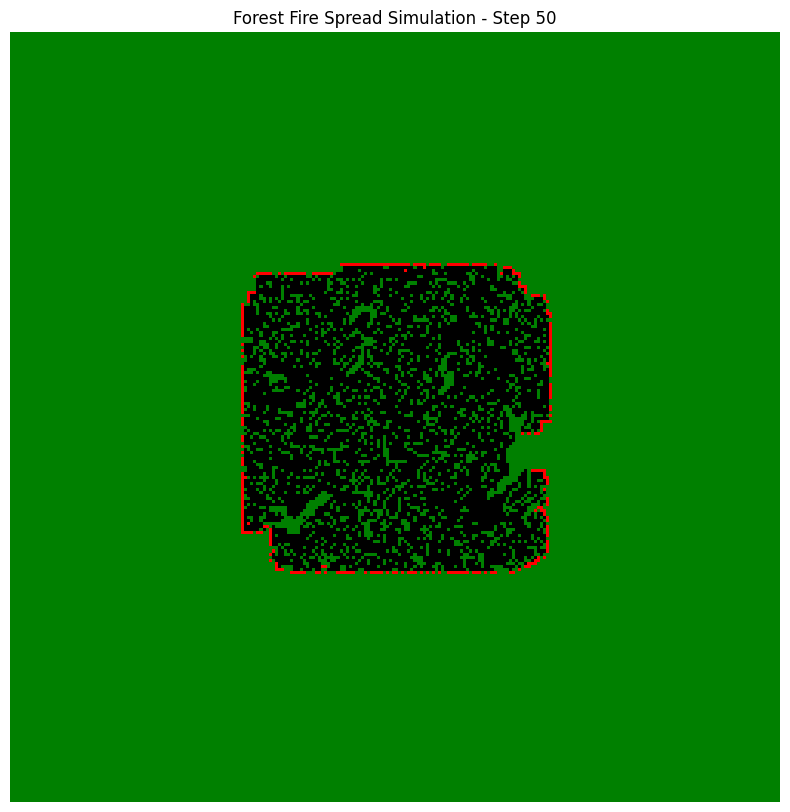

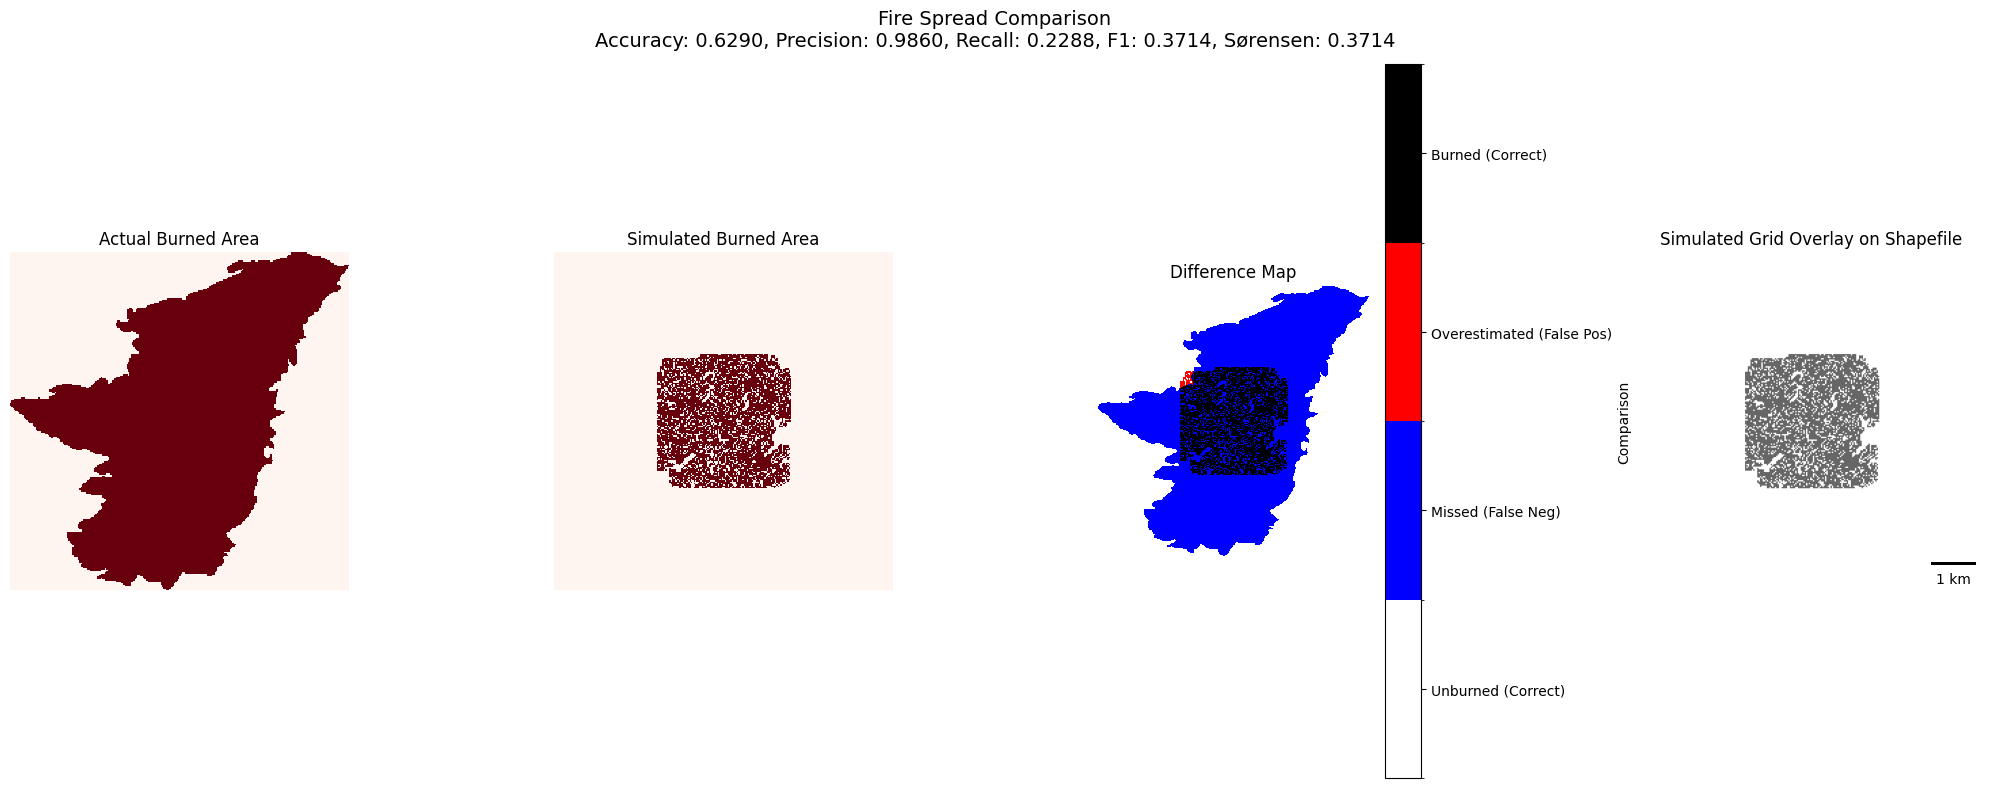

In [33]:
# Run the fully advanced model
advanced_model, advanced_history, advanced_env = run_advanced_model(fire, optimal_params, steps=50, dt=0.1)

In [35]:
from src.interventions import apply_firebreak_strategy, apply_early_detection_strategy, apply_direct_attack_strategy, apply_point_protection_strategy


Evaluating strategy: No Intervention (Baseline)
Description: No firefighting intervention
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.008195230453712342, tp: 0.35, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4799111862778719, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob: 17.499650855950353, tp: 0.225, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.46067414587546823, exceeds_threshold: True
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.0001882275857178358, tp: 0

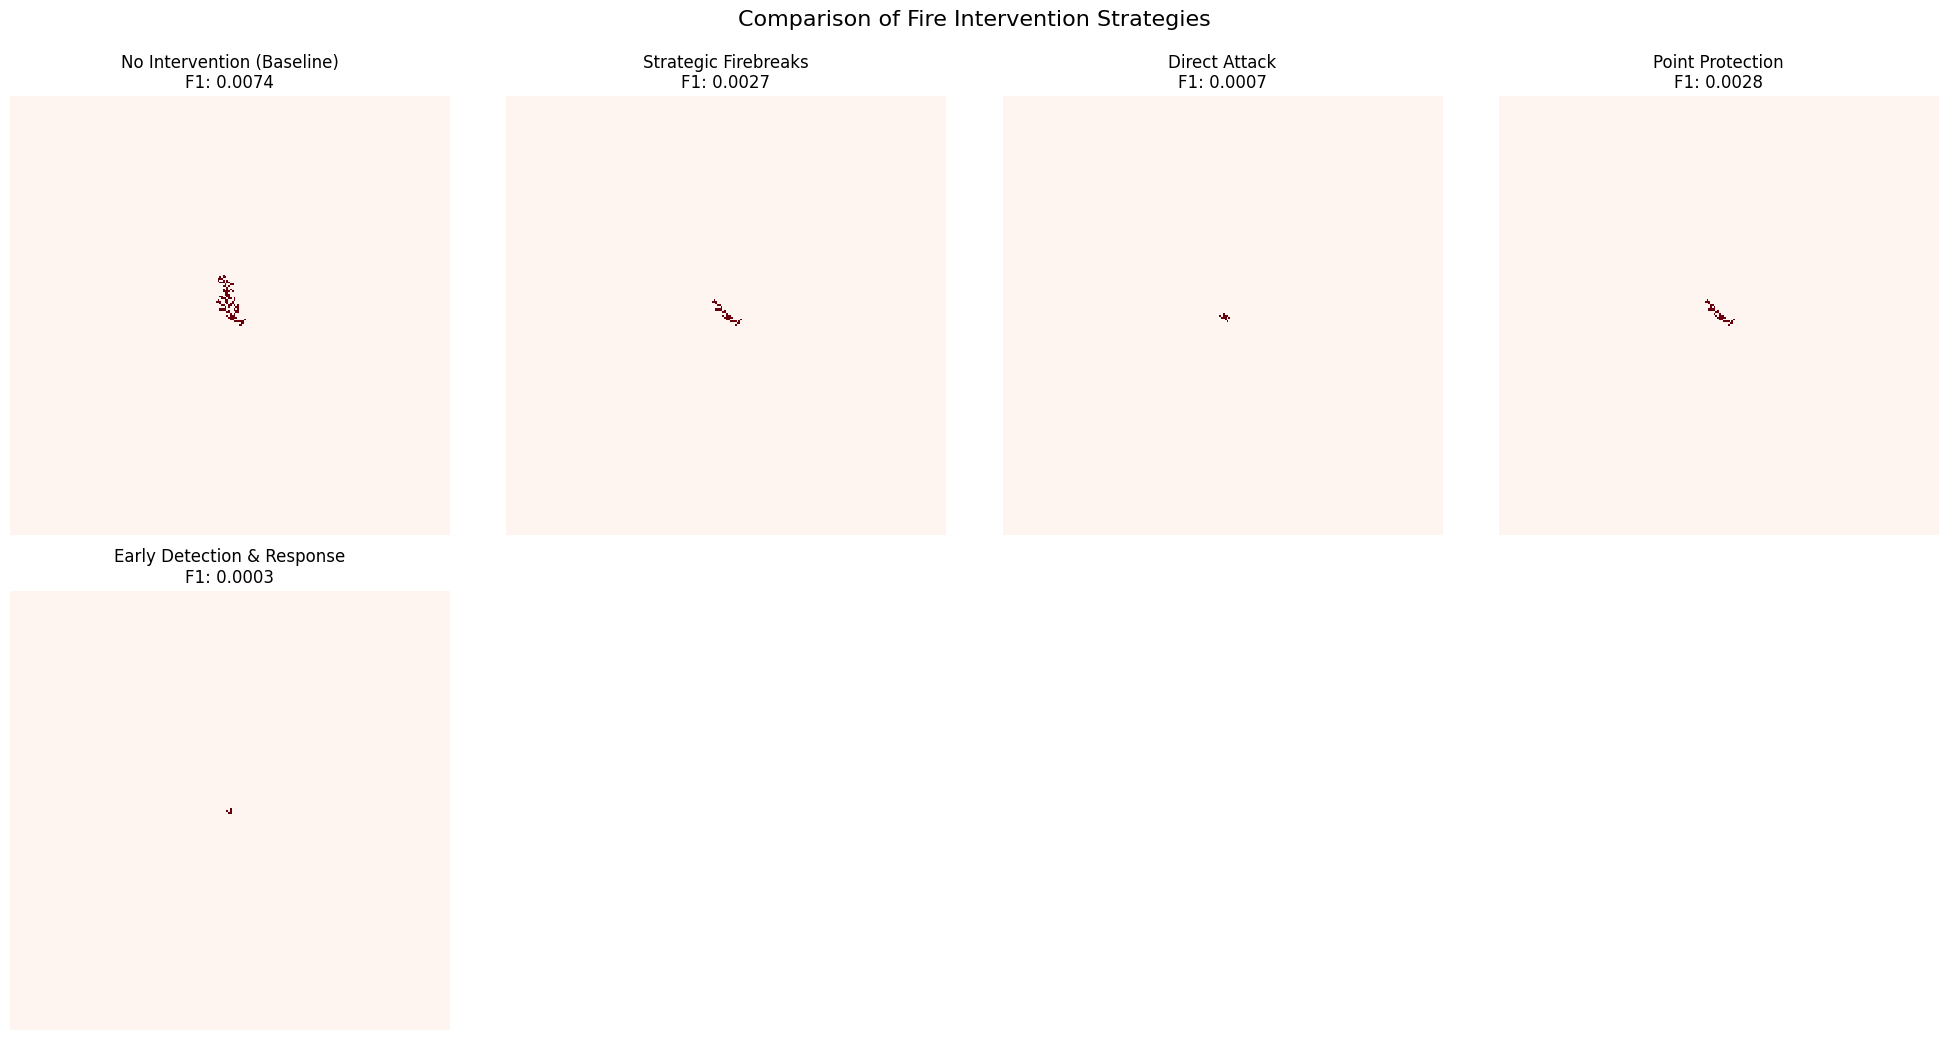

In [ ]:
# Define intervention strategies
strategies = {
    'no_intervention': {
        'name': 'No Intervention (Baseline)',
        'description': 'No firefighting intervention',
        'function': lambda model, steps: model.run_simulation(steps)
    },
    'firebreaks': {
        'name': 'Strategic Firebreaks',
        'description': 'Create firebreaks to control fire spread',
        'function': apply_firebreak_strategy
    },
    'direct_attack': {
        'name': 'Direct Attack',
        'description': 'Directly attack the fire front with fire retardant',
        'function': apply_direct_attack_strategy
    },
    'point_protection': {
        'name': 'Point Protection',
        'description': 'Focus resources on protecting specific high-value points',
        'function': apply_point_protection_strategy
    },
    'early_detection': {
        'name': 'Early Detection & Response',
        'description': 'Early detection and rapid initial attack',
        'function': apply_early_detection_strategy
    }
}

# Store results for comparison
results = {}
baseline_result = None

# Create a figure for visualisation of all strategies
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Set the initial fire locations
initial_fire = [(50, 50)]

# Run simulation for each strategy
for i, (strategy_id, strategy) in enumerate(strategies.items()):
    print(f"\nEvaluating strategy: {strategy['name']}")
    print(f"Description: {strategy['description']}")

    # Clone the base model for this strategy
    model = CA(grid_size=grid_size, cell_size=1)
    model.load_mtbs_fire_data(fire)
    model.initialise_ndvi_from_data(fire)
    model.load_terrain_data(slope, aspect, elevation)
    model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50, humidity=5, fire_direction=20)
    # model.set_initial_fire(initial_fire)

    # Apply the strategy and run simulation
    history = strategy['function'](model, 200)

    # Evaluate results
    if model.actual_burned_area is not None:
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Save metrics
        results[strategy_id] = {
            'name': strategy['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'sorensen': sorensen,
            'burned_area': np.sum(model.grid == 2),  # Count of burned cells
            'burnt_grid': (model.grid == 2).astype(int)  # Save the burnt grid for visualisation
        }

        # Save baseline result for comparison
        if strategy_id == 'no_intervention':
            baseline_result = results[strategy_id]

        # Plot results
        ax = axes[i]
        ax.imshow(model.grid == 2, cmap='Reds', interpolation='none')
        ax.set_title(f"{strategy['name']}\nF1: {f1:.4f}")
        ax.axis('off')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Burned Area: {results[strategy_id]['burned_area']} cells")

        # Calculate fire containment percentage if not baseline
        if baseline_result and strategy_id != 'no_intervention':
            containment = 1.0 - (results[strategy_id]['burned_area'] / baseline_result['burned_area'])
            containment_pct = max(0, containment * 100)
            results[strategy_id]['containment_pct'] = containment_pct
            print(f"  Fire Containment: {containment_pct:.1f}%")

# Fill any unused subplot spaces
for i in range(len(strategies), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Comparison of Fire Intervention Strategies", fontsize=16, y=1.02)
plt.show()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_29536\3761053530.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(strategies, rotation=45, ha='right')
C:\Users\Daniel\AppData\Local\Temp\ipykernel_29536\3761053530.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strategies, rotation=45, ha='right')


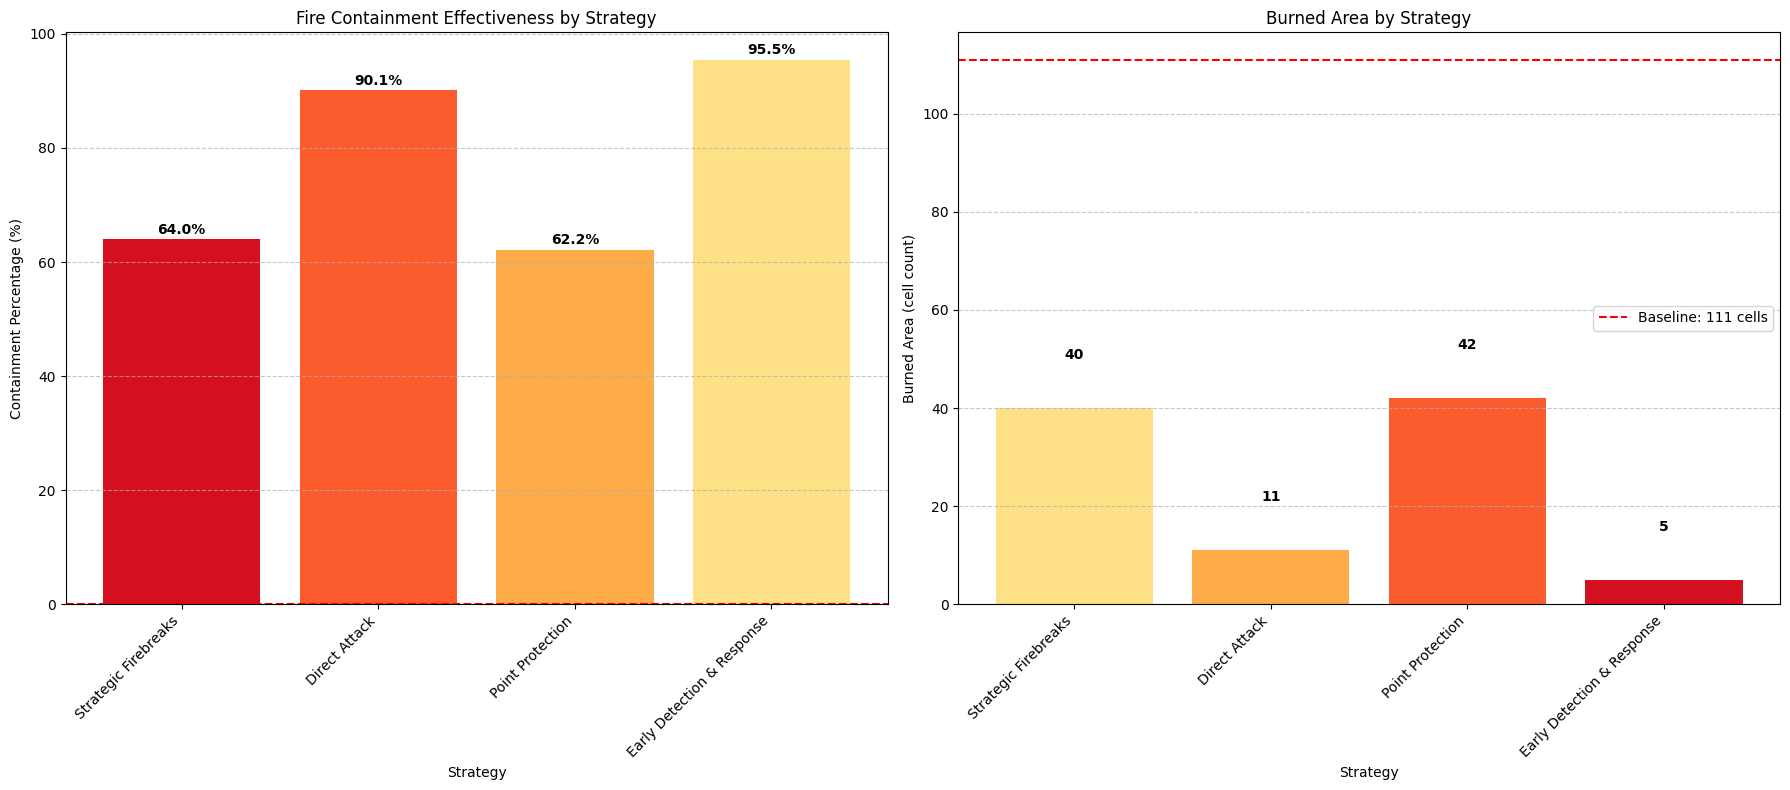

In [ ]:
# Extract strategy names and containment percentages
strategies = []
containment_pcts = []
burned_areas = []

for strategy_id, metrics in results.items():
    if strategy_id != 'no_intervention':
        strategies.append(metrics['name'])
        containment_pcts.append(metrics.get('containment_pct', 0))
        burned_areas.append(metrics['burned_area'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot containment percentages
containment_colors = plt.cm.YlOrRd(np.linspace(0.8, 0.2, len(strategies)))
ax1.bar(strategies, containment_pcts, color=containment_colors)
ax1.set_title('Fire Containment Effectiveness by Strategy')
ax1.set_ylabel('Containment Percentage (%)')
ax1.set_xlabel('Strategy')
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
ax1.axhline(y=0, color='r', linestyle='--', label='Baseline (No Intervention)')

# Add labels on bars
for i, v in enumerate(containment_pcts):
    ax1.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# Plot burned areas
burned_colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(strategies)))
ax2.bar(strategies, burned_areas, color=burned_colors)
ax2.set_title('Burned Area by Strategy')
ax2.set_ylabel('Burned Area (cell count)')
ax2.set_xlabel('Strategy')
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
baseline_area = baseline_result['burned_area']
ax2.axhline(y=baseline_area, color='r', linestyle='--', label=f'Baseline: {baseline_area} cells')
ax2.legend()

# Add labels on bars
for i, v in enumerate(burned_areas):
    ax2.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()




## Conclusion

The enhanced wildfire model now incorporates three advanced mathematical approaches:

1. **Percolation Theory Integration**: Improves fire spread modeling by accounting for critical thresholds in fuel connectivity, creating more realistic fire spread patterns, especially in heterogeneous landscapes.

2. **Stochastic Differential Equations for Environmental Conditions**: Models the dynamic, stochastic nature of environmental conditions like wind, temperature, humidity, and precipitation, leading to more realistic temporal evolution during simulations.

3. **Bayesian Parameter Estimation**: Provides full posterior distributions for model parameters rather than just point estimates, allowing for better quantification of parameter uncertainty.

These enhancements significantly improve the realism and physical accuracy of the wildfire spread model while maintaining computational efficiency.

In [19]:
from src.interventions import apply_firebreak_strategy, apply_early_detection_strategy, apply_direct_attack_strategy, apply_point_protection_strategy


Evaluating strategy: Direct Attack
Description: Directly attack the fire front with fire retardant
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.008954048088315333, tp: 0.475, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4576889640556497, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob: 21.07100817349124, tp: 0.475, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.46067414587546823, exceeds_threshold: True
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.00017757319407343

 prob: 0.5, we: 0.10375017142416093, a_prob: 106242405.0566786, tp: 0.4, p_density: 0.8262041052999467, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.44637835048251906, exceeds_threshold: True
 prob: 0.5, we: 0.10375017142416093, a_prob: 4.567843527335368e-05, tp: 0.35, p_density: 0.820421257769282, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4397037796459426, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob: 7.17358019756401e-07, tp: 0.4, p_density: 0.815266135285081, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4551326668295565, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.0017919613783872889, tp: 0.375, p_density: 0.8265235372506848, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4380601595102723, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob:

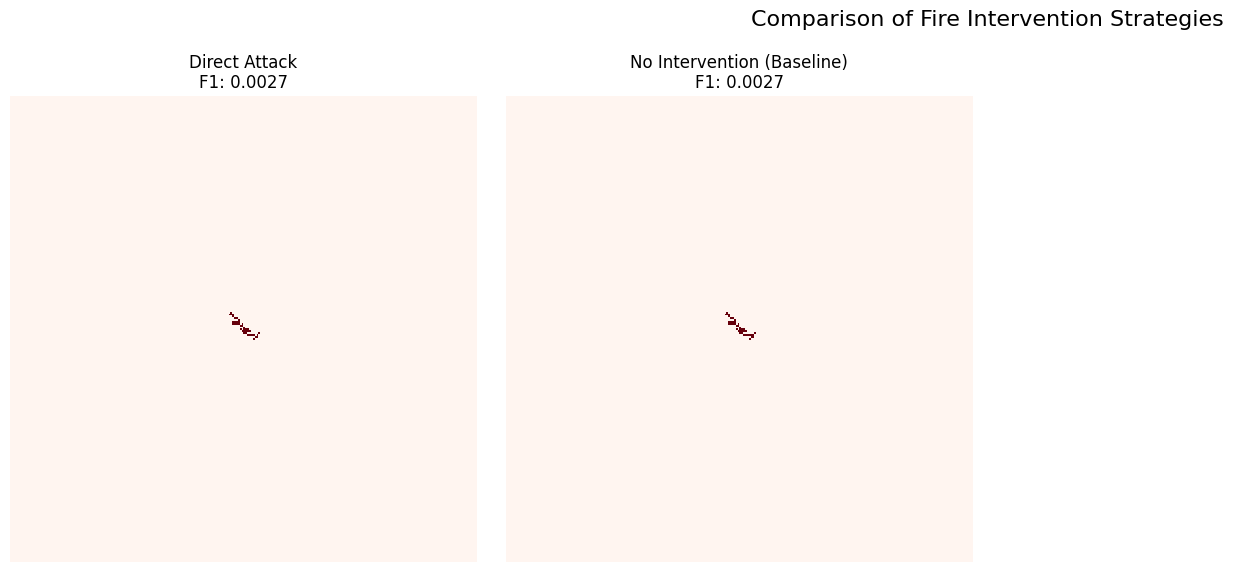

In [27]:
# Define intervention strategies
strategies = {
    'direct_attack': {
        'name': 'Direct Attack',
        'description': 'Directly attack the fire front with fire retardant',
        'function': apply_direct_attack_strategy
    },
        'no_intervention': {
        'name': 'No Intervention (Baseline)',
        'description': 'No firefighting intervention',
        'function': lambda model, steps: model.run_simulation(steps)
    },

}

# Store results for comparison
results = {}
baseline_result = None

# Create a figure for visualisation of all strategies
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Set the initial fire locations
initial_fire = [(50, 50)]

# Run simulation for each strategy
for i, (strategy_id, strategy) in enumerate(strategies.items()):
    print(f"\nEvaluating strategy: {strategy['name']}")
    print(f"Description: {strategy['description']}")

    # Clone the base model for this strategy
    model = CA(grid_size=grid_size, cell_size=1)
    model.load_mtbs_fire_data(fire)
    model.initialise_ndvi_from_data(fire)
    model.load_terrain_data(slope, aspect, elevation)
    model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50, humidity=5, fire_direction=20)
    # model.set_initial_fire(initial_fire)

    # Apply the strategy and run simulation
    history = strategy['function'](model, 200)

    # Evaluate results
    if model.actual_burned_area is not None:
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Save metrics
        results[strategy_id] = {
            'name': strategy['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'sorensen': sorensen,
            'burned_area': np.sum(model.grid == 2),  # Count of burned cells
            'burnt_grid': (model.grid == 2).astype(int)  # Save the burnt grid for visualisation
        }

        # Save baseline result for comparison
        if strategy_id == 'no_intervention':
            baseline_result = results[strategy_id]

        # Plot results
        ax = axes[i]
        ax.imshow(model.grid == 2, cmap='Reds', interpolation='none')
        ax.set_title(f"{strategy['name']}\nF1: {f1:.4f}")
        ax.axis('off')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Burned Area: {results[strategy_id]['burned_area']} cells")

        # Calculate fire containment percentage if not baseline
        if baseline_result and strategy_id != 'no_intervention':
            containment = 1.0 - (results[strategy_id]['burned_area'] / baseline_result['burned_area'])
            containment_pct = max(0, containment * 100)
            results[strategy_id]['containment_pct'] = containment_pct
            print(f"  Fire Containment: {containment_pct:.1f}%")

# Fill any unused subplot spaces
for i in range(len(strategies), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Comparison of Fire Intervention Strategies", fontsize=16, y=1.02)
plt.show()